<h1 align="center">Software Introspection for Signaling Emergent Cyber-Social Operations (SIGNAL)</h1>
<h2 align="center">SRI International</h2>
<h3 align="center">In support of DARPA AIE Hybrid AI to Protect Integrity of Open Source Code (SocialCyber)</h3>

### For any questions regarding this notebook, please contact:
* Huascar Sanchez (PI) at [huascar.sanchez@sri.com](mailto:huascar.sanchez@sri.com)
* Briland Hitaj at [briland.hitaj@sri.com](mailto:briland.hitaj@sri.com)

## Handling Imbalanced Data Present in the Annotated Persuasion for Good Dataset (P4G)

**Summary:** In practice, datasets are often imbalanced, i.e., having varying representations among classes. Training a machine learning (ML) model on imbalanced data can provide a misleading sense of security, affecting the performance of the model on **new** test samples. 

*Note* that imbalances' effect on performance is related to the model you are using.

In this notebook, we provide a step-by-step demonstration of our approach in handling the problem of imbalance in P4G dataset.

### Table of Contents

0. [Getting Started](#getting-started)
1. [Download the P4G annotated data](#p4g-download)
2. [Load the P4G Dataset](#p4g-load)
3. [Clean the P4G Dataset](#p4g-clean)
4. [Resampling the imbalanced persuasion data](#p4g-resample)
5. [Saving the training and test sets](#p4g-save)

### 0. Getting Started <a class="anchor" id="getting-started"></a>

In [1]:
import os
import sys

# adding the parent directory of the current folder to the PATH variable
PARENT_DIR = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(PARENT_DIR)

In [2]:
# import relevant libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# relevant packages to handle the imbalanced data
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

# relevant utility methods located in utils.py file under utils folder
from utils.utils import path_exists, download_file

%matplotlib inline

The annotated P4G dataset is in **.xlsx** format.
- **openpyxl** library helps pandas load a .xlsx file into a DataFrame
- We check whether **openpyxl** is present, otherwise throw an [ImportError](https://docs.python.org/3/library/exceptions.html#ImportError)

In [3]:
try:
    import openpyxl
except ImportError:
    !pip install openpyxl

### 1. Download the P4G annotated data <a class="anchor" id="p4g-download"></a>

The next cell checks to see if the P4G annotaded dataset (**300_dialog.xlsx**) exists within the **/data** directory, otherwise it attempts to download the annotaded P4G dataset from its' respective GitLab repository, see [HERE](https://gitlab.com/ucdavisnlp/persuasionforgood/-/raw/master/data/AnnotatedData/300_dialog.xlsx).

In [4]:
# download P4G annotated data
p4g_data_url = "https://gitlab.com/ucdavisnlp/persuasionforgood/-/raw/master/data/AnnotatedData/300_dialog.xlsx"
destination_folder = os.path.join(PARENT_DIR, 'data')
p4g_data_file = "300_dialog.xlsx"
p4g_data_path = os.path.join(destination_folder, p4g_data_file)

if path_exists(p4g_data_path):
    print(f"- {p4g_data_file} already exists.")
else:
    download_file(url=p4g_data_url, dest_folder=destination_folder)

- 300_dialog.xlsx already exists.


### 2. Load the P4G Dataset <a class="anchor" id="p4g-load"></a>

In [5]:
# load the P4G dataset into a pandas DataFrame
p4g_df = pd.read_excel(p4g_data_path)

In [6]:
# print info about DataFrame and each respective column
p4g_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10864 entries, 0 to 10863
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  10864 non-null  int64  
 1   B2          10864 non-null  object 
 2   B4          10864 non-null  int64  
 3   Turn        10864 non-null  int64  
 4   Unit        10864 non-null  object 
 5   er_label_1  6017 non-null   object 
 6   ee_label_1  4847 non-null   object 
 7   er_label_2  22 non-null     object 
 8   ee_label_2  15 non-null     object 
 9   neg         10235 non-null  float64
 10  neu         10235 non-null  float64
 11  pos         10235 non-null  float64
dtypes: float64(3), int64(3), object(6)
memory usage: 1018.6+ KB


In [7]:
# show the first 5-records present in the DataFrame
p4g_df.head()

,Unnamed: 0,B2,B4,Turn,Unit,er_label_1,ee_label_1,er_label_2,ee_label_2,neg,neu,pos
0,0,20180719-210146_172_live,0,0,Hello.,greeting,NaN,NaN,NaN,0.0,1.000,0.000
1,1,20180719-210146_172_live,0,0,How are you?,greeting,NaN,NaN,NaN,0.0,1.000,0.000
2,2,20180719-210146_172_live,1,0,"I'm good, how are you doing?",NaN,greeting,NaN,NaN,0.0,0.633,0.367
3,3,20180719-210146_172_live,0,1,Very well.,greeting,NaN,NaN,NaN,0.0,0.295,0.705
4,4,20180719-210146_172_live,0,1,I'm just up organizing info for my charity.,other,NaN,NaN,NaN,0.0,0.714,0.286


### 3. Clean the P4G Dataset <a class="anchor" id="p4g-clean"></a>

We drop a series of columns from the **p4g_df** DataFrame, as they are either empty or not relevant for the task considered in this notebook.

In [8]:
unkn_feat = ['Unnamed: 0', 'B2', 'B4', 'Turn', 'ee_label_1', 'er_label_2', 'ee_label_2']
p4g_df.drop(unkn_feat, axis=1, inplace=True)
p4g_df.head()

,Unit,er_label_1,neg,neu,pos
0,Hello.,greeting,0.0,1.000,0.000
1,How are you?,greeting,0.0,1.000,0.000
2,"I'm good, how are you doing?",NaN,0.0,0.633,0.367
3,Very well.,greeting,0.0,0.295,0.705
4,I'm just up organizing info for my charity.,other,0.0,0.714,0.286


Filter by persuasion strategies in Wang et al. paper
- Labels extracted from Table 3 in the paper, see [HERE](https://arxiv.org/pdf/1906.06725.pdf).
- We remove the 'non-strategy dialogue acts' from consideration

In [9]:
paper_persuasion_strategies = ['logical-appeal', 'emotion-appeal', 'credibility-appeal', 'foot-in-the-door', 
                               'self-modeling', 'personal-story', 'donation-information', 'source-related-inquiry',
                               'task-related-inquiry', 'personal-related-inquiry']

filtered_p4g_df = p4g_df.loc[p4g_df['er_label_1'].isin(paper_persuasion_strategies)]
filtered_p4g_df.head()

,Unit,er_label_1,neg,neu,pos
5,Are you involved with charities?,task-related-inquiry,0.0,0.556,0.444
18,Do you currently donate to your charity?,task-related-inquiry,0.0,0.682,0.318
22,Save The Children is an international non-gove...,credibility-appeal,0.0,0.533,0.467
28,These children really need the assistance.,logical-appeal,0.0,1.000,0.000
34,Do you have any more questions for me?,task-related-inquiry,0.0,1.000,0.000


In [10]:
p4g_clean = filtered_p4g_df.apply(lambda x: x.fillna(x.value_counts().index[0]))
p4g_clean.head()

,Unit,er_label_1,neg,neu,pos
5,Are you involved with charities?,task-related-inquiry,0.0,0.556,0.444
18,Do you currently donate to your charity?,task-related-inquiry,0.0,0.682,0.318
22,Save The Children is an international non-gove...,credibility-appeal,0.0,0.533,0.467
28,These children really need the assistance.,logical-appeal,0.0,1.000,0.000
34,Do you have any more questions for me?,task-related-inquiry,0.0,1.000,0.000


Add numerical IDs to each persuasion label ('er_label_1') present in the DataFrame to facilitate the machine learning tasks

In [11]:
p4g_clean['persuasion_id'] = p4g_clean['er_label_1'].factorize()[0]
p4g_clean.head()

,Unit,er_label_1,neg,neu,pos,persuasion_id
5,Are you involved with charities?,task-related-inquiry,0.0,0.556,0.444,0
18,Do you currently donate to your charity?,task-related-inquiry,0.0,0.682,0.318,0
22,Save The Children is an international non-gove...,credibility-appeal,0.0,0.533,0.467,1
28,These children really need the assistance.,logical-appeal,0.0,1.000,0.000,2
34,Do you have any more questions for me?,task-related-inquiry,0.0,1.000,0.000,0


In [12]:
p4g_clean.isnull().values.any()

False

In [13]:
p4g_clean.groupby('persuasion_id').mean()

,neg,neu,pos
persuasion_id,,,
0,0.018796,0.817372,0.163827
1,0.034776,0.729323,0.235905
2,0.031522,0.760143,0.208326
3,0.009423,0.794476,0.196095
4,0.000000,0.718461,0.281539
5,0.005167,0.889953,0.104882
6,0.011679,0.819481,0.168840
7,0.207944,0.696053,0.096003
8,0.008061,0.794417,0.197509


Create a dictionary (**id2label**) mapping the assigned **persuasion_id**s with the respective label name, i.e., **er_label_1**.

In [14]:
# persuasionID -> persuasion label
id2label = dict(zip(p4g_clean['persuasion_id'], p4g_clean['er_label_1']))
id2label

{0: 'task-related-inquiry',
 1: 'credibility-appeal',
 2: 'logical-appeal',
 3: 'personal-related-inquiry',
 4: 'source-related-inquiry',
 5: 'donation-information',
 6: 'foot-in-the-door',
 7: 'emotion-appeal',
 8: 'self-modeling',
 9: 'personal-story'}

Remove the **er_label_1** column from the DataFrame.

In [15]:
unkn_feat = ['er_label_1']
p4g_clean.drop(unkn_feat, axis=1, inplace=True)
p4g_clean.head()

,Unit,neg,neu,pos,persuasion_id
5,Are you involved with charities?,0.0,0.556,0.444,0
18,Do you currently donate to your charity?,0.0,0.682,0.318,0
22,Save The Children is an international non-gove...,0.0,0.533,0.467,1
28,These children really need the assistance.,0.0,1.000,0.000,2
34,Do you have any more questions for me?,0.0,1.000,0.000,0


We proceed by plotting the total number of record for each label/class present in the **p4g_df** DataFrame. As it can be noted from the plot, the dataset is highly imbalanced, with classes such **credibility-appeal**, i.e., persuasion_id: **1**, having more than 1,000-record, as opposed to others such as **foot-in-the-door**, i.e., persuasion_id: **6**, with less that 200-records.

In [16]:
ax = p4g_clean.groupby(['persuasion_id']).size()
ax

persuasion_id
0     191
1    1083
2     469
3     168
4     180
5     491
6     162
7     377
8     163
9     153
dtype: int64

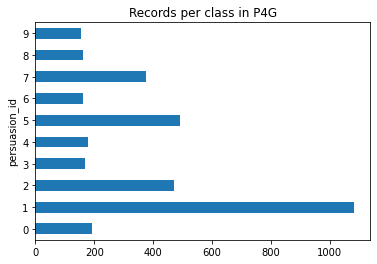

In [17]:
ax.plot(kind='barh', rot=0, title="Records per class in P4G")
plt.show()

### 4. Resampling the imbalanced persuasion data <a class="anchor" id="p4g-resample"></a>

In [18]:
# Separating the independent variables from dependent variables
X = p4g_clean.iloc[:,:-1]
y = p4g_clean.iloc[:,-1]
X.shape, y.shape

((3437, 4), (3437,))

In [19]:
X.head()

,Unit,neg,neu,pos
5,Are you involved with charities?,0.0,0.556,0.444
18,Do you currently donate to your charity?,0.0,0.682,0.318
22,Save The Children is an international non-gove...,0.0,0.533,0.467
28,These children really need the assistance.,0.0,1.000,0.000
34,Do you have any more questions for me?,0.0,1.000,0.000


In [20]:
# Split train-test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=1, stratify=y)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3265, 4), (3265,), (172, 4), (172,))

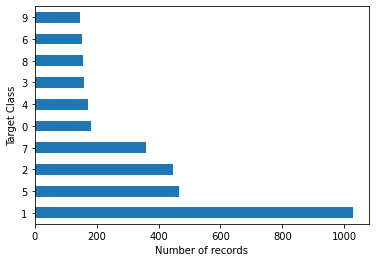

In [21]:
count = y_train.value_counts()

count.plot.barh()
plt.xlabel('Number of records')
plt.ylabel('Target Class')
plt.show()

In [22]:
# summarize class distribution
print(f"Class distribution before resampling:\n{count}")

Class distribution before resampling:
1    1029
5     466
2     446
7     358
0     181
4     171
3     160
8     155
6     154
9     145
Name: persuasion_id, dtype: int64


In [23]:
# define undersampling strategy
undersample = RandomUnderSampler(sampling_strategy='all')

# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy='all')

# define pipeline
pipeline = Pipeline(steps=[('o', oversample), ('u', undersample)])

In [24]:
# resample
X_resampled, y_resampled = pipeline.fit_resample(X_train, y_train)

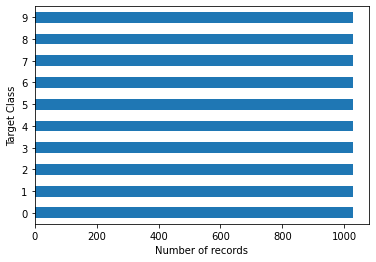

In [25]:
count_resampled = y_resampled.value_counts()

count_resampled.plot.barh()
plt.xlabel('Number of records')
plt.ylabel('Target Class')
plt.show()

In [26]:
# summarize class distribution
print(f"Class distribution after resampling:\n{count_resampled}")

Class distribution after resampling:
0    1029
1    1029
2    1029
3    1029
4    1029
5    1029
6    1029
7    1029
8    1029
9    1029
Name: persuasion_id, dtype: int64


In [27]:
X_resampled.shape, y_resampled.shape

((10290, 4), (10290,))

In [28]:
X_resampled.head()

,Unit,neg,neu,pos
0,Where would you like to focus your donation?,0.000,0.737,0.263
1,You ever do one of these chat tasks before?,0.000,1.000,0.000
2,Do you have questions?,0.000,1.000,0.000
3,did they ever did a big mistake that was all o...,0.179,0.821,0.000
4,Would you like to help an important cause?,0.000,0.417,0.583


In [29]:
X_filtered = X_resampled['Unit']
y_filtered = y_resampled.to_numpy()
X_filtered.shape, y_filtered.shape

((10290,), (10290,))

### 5. Saving the Training and Test Sets <a class="anchor" id="p4g-save"></a>

In [30]:
# X_train, X_test, y_train, y_test
# X_resampled.shape, y_resampled.shape
X_train.to_pickle(os.path.join(destination_folder, 'x_train_imbalanced.pkl'))
X_test.to_pickle(os.path.join(destination_folder, 'x_test_imbalanced.pkl'))
y_train.to_pickle(os.path.join(destination_folder, 'y_train_imbalanced.pkl'))
y_test.to_pickle(os.path.join(destination_folder, 'y_test_imbalanced.pkl'))
X_resampled.to_pickle(os.path.join(destination_folder, 'x_resampled_balanced.pkl'))
y_resampled.to_pickle(os.path.join(destination_folder, 'y_resampled_balanced.pkl'))

### What's next?

* We move on to training and testing machine learning models on the P4G data, see [01_signal_persuasion_classification.ipynb](./01_signal_persuasion_classification.ipynb)